# Intro to Snorkel: Extracting Spouse Relations from the News

## Part II: Generating _and modeling_ noisy training labels

In this part of the tutorial, we will write **labeling functions** which express various heuristics, patterns, and [_weak supervision_](http://hazyresearch.github.io/snorkel/blog/weak_supervision.html) strategies to label our data.

In most real-world settings, hand-labeled training data is prohibitively expensive and slow to collect. A common scenario, though, is to have access to tons of _unlabeled_ training data, and have some idea of how to label it programmatically. For example:

* We may be able to think of text patterns that would indicate two people mentioned in a sentence are married, such as seeing the word "spouse" between the mentions.
* We may have access to an external _knowledge base (KB)_ that lists some known pairs of married people, and can use these to heuristically label some subset of our data.

Our labeling functions will capture these types of strategies. We know that these labeling functions will not be perfect, and some may be quite low-quality, so we will _model_ their accuracies with a generative model, which Snorkel will help us easily apply.

This will ultimately produce a single set of **noise-aware training labels**, which we will then use to train an end extraction model in the next notebook.  For more technical details of this overall approach, see our [NIPS 2016 paper](https://arxiv.org/abs/1605.07723).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os

# TO USE A DATABASE OTHER THAN SQLITE, USE THIS LINE
# Note that this is necessary for parallel execution amongst other things...
# os.environ['SNORKELDB'] = 'postgres:///snorkel-intro'

import numpy as np
from snorkel import SnorkelSession
session = SnorkelSession()

We repeat our definition of the `Spouse` `Candidate` subclass from Parts II and III.

In [2]:
from snorkel.models import candidate_subclass

#Spouse = candidate_subclass('Spouse', ['person1', 'person2'])
Trend = candidate_subclass('Trend', ['tr'])

### Using a labeled _development set_

In our setting here, we will use the phrase "development set" to refer to a _small_ set of examples (here, a subset of our training set) which we label by hand and use to help us develop and refine labeling functions. Unlike the _test set_, which we do not look at and use for final evaluation, we can inspect the development set while writing labeling functions.

In our case, we already loaded existing labels for a development set (`split` 1), so we can load them again now:

In [3]:
from snorkel.annotations import load_gold_labels

L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
# print(L_gold_dev)

# Creating and Modeling a Noisy Training Set

Our biggest step in the data programming pipeline is the creation - _and modeling_ - of a noisy training set.  We'll approach this in three main steps:

1. **Creating labeling functions (LFs):** This is where most of our development time would actually go into if this were a real application. Labeling functions encode our heuristics and weak supervision signals to generate (noisy) labels for our training candidates.

2. **Applying the LFs:** Here, we actually use them to label our candidates!

3. **Training a generative model of our training set:** Here we learn a model over our LFs, learning their respective accuracies automatically. This will allow us to combine them into a single, higher-quality label set.

We'll also add some detail on how to go about _developing labeling functions_ and then _debugging our model_ of them to improve performance.

## 1. Creating Labeling Functions

In Snorkel, our primary interface through which we provide training signal to the end extraction model we are training is by writing **labeling functions (LFs)** (as opposed to hand-labeling massive training sets).  We'll go through some examples for our spouse extraction task below.

A labeling function is just a Python function that accepts a `Candidate` and returns `1` to mark the `Candidate` as true, `-1` to mark the `Candidate` as false, and `0` to abstain from labeling the `Candidate` (note that the non-binary classification setting is covered in the advanced tutorials!).

In the next stages of the Snorkel pipeline, we'll train a model to learn the accuracies of the labeling functions and trewieght them accordingly, and then use them to train a downstream model. It turns out by doing this, we can get high-quality models even with lower-quality labeling functions. So they don't need to be perfect! Now on to writing some:

In [4]:
import re
from snorkel.lf_helpers import (
    get_left_tokens, get_right_tokens, get_between_tokens,
    get_text_between, get_tagged_text,get_sent_candidate_spans
)

### Pattern-based LFs
These LFs express some common sense text patterns which indicate that a person pair might be married. For example, `LF_husband_wife` looks for words in `spouses` between the person mentions, and `LF_same_last_name` checks to see if the two people have the same last name (but aren't the same whole name).

In [38]:
import re 
import spacy
nlp = spacy.load('en')
trend_lexicon = {
            "unknown": ["seasonality",  "consistent", "rebound", "average", "exceed"
                        "steadily", "regain", "rebound", "retrace", "hyperdemic", "advance", "retreat", "up", "fall", "growth"
                        "trend", "bounce"],
            "single": ["peak", "minima", "maxima", "slip", "minimum", "maximum", "jump", "leap", "highest", "lowest"],
            "linear": ["reduce", "reduction",  "increase", "rise", "rising", "grow", "flat",
                       "drop", "gain", "downtrend", "plummet", "descend", "down", "decline", "downward", "firm"], # I removed the word "fall" from the candidates
            "UNK": ["correlation", "teeter", "progression", "progress", "random", "polynomial", "parabolic",
                    "hyperdemic", "trend", "exponential", "exponentially"],
            "LIN": ["downfall", "downtrend", "advance", "uptrend", "linear", "increase", "decrease", "decline",
                     "grow", "rise", "drop", "climbs", "descend", "decay", "constant", "slope",
                    "increment", "decrement", "plummet", "reduce", "ascent", "descent",
                    "reduce", "reduction", "increase", "rise", "rising", "grow", "flat", "drop",
                    "gain", "downtrend", "descend", "decline", "downward"],
            "SING": ["bump", "spike", "spiking", "crest", "jump", "pulse", "anomalous", "outlier", "gap", "peak",
                     "valley", "slip", "bounce", "jump", "leap"],
            "VAL": ["maximum", "minimum", "peak", "minima", "maxima", "average"],
            "OSC-VAR": ["inconsistent", "consistent", "hover", "steadily", "volatile", "steady", "oscillate", "flux",
                        "turbulence", "fluctuation", "fluctuate", "inflexion", "oscillation", "steady", "vacillate",
                        "cluster", "variation", "stabilize", "variance", "disperse", "settle", "divergent",
                        "consistent"],
            "SEC-LIN": ["acceleration", "accelerate", "regain", "downturn", "rebound", "retreat", "retrace",
                        "turnaround"],
            "CYC": ["wave", "sinusodal", "seasonality", "cycle", "cyclic", "sine"]
        }
value_kw = ["above", "below", "level", "rate", "level", "percent", "compare", "between", "high", "low", "highest", "record", "less"]



def is_indicator(c): # c can be string of any lenght
    if c in bi_words:
        return True
    if c in bi_words_src:
        return True
    if c in trip_words:
        return True
    return False
    
def poss_indicator(c):
    if c in single_words:
        return True
    if c in single_src_words:
        return True
    return False

def count_indicators(sent): # assumption for now is the spacy sentence
    num = 0
    for i in range(len(sent) - 1):
        bi_word = str(sent[i].text).lower() + " " + str(sent[i+1].text).lower()
#         print(bi_word)
        if is_indicator(bi_word):
            num += 1
#             print(bi_word)
        if i+2 < len(sent):
            trip_word = bi_word + " " + str(sent[i+2].text).lower()
            if is_indicator(trip_word):
                num += 1
        if poss_indicator(str(sent[i]).lower()):
            num += 0.5
    return num
    

def load_word_file(name):
    in_file = open('data/'+ name)
    w_dict = set([])
    for w in in_file.readlines():
        w_dict.add(w)
    return w_dict

def in_trend_lexicon(c):
    for kw in trend_lexicon.keys():
        if c.lower() in trend_lexicon[kw]:
            return True
    return False

def get_spacy_sent(s):
    sent = nlp(get_tagged_text(s).replace('{{A}}', str(s.tr.get_span())))
#     print(sent)
    return sent
    
def get_spacy_token(s, spacy_sent, distance):
    step = 0
    self_token = None
    tmp = str(s)
    token_place = re.search(r'words=\[.*\]', tmp)
    tmp = token_place[0].split(",")[1]
    token_ind = int(tmp[:-1])
    for token in spacy_sent:
        step += 1
        if step == token_ind + distance + 1:
            return token
    return None
   
def LF_up_down(s):
    sent = get_spacy_sent(s)
    s_token = get_spacy_token(s, sent, 0)
    if str(s_token.lemma_).lower() in ["up", "down"]:
        if str(s_token.pos_) == "PART" and str(s_token.pos_) == 'ADP':
            if str(s_token.head.pos_) == "VERB":
                phrasal_v = str(s_token.head.lemma_) + " " + str(s_token.lemma_)
                print(phrasal_v)
            #print("This is the phrasal verb to be evaluated " + phrasal_v)
                if phrasal_v in ["move up", "go up", "fall down", "cut down"]:
                    return 1
                return -1
        
        tmp = get_right_tokens(c, window=1, attrib='words', n_max=1, case_sensitive=False)
        for x in tmp:
            if str(x).lower() in ['from']: #, 'to']:
                return 1
        if str(s_token.dep_) == 'advmod':
            return 1
        return -1 # TODO: check if this should be 0
    return 0

def LF_decline(s):
    sent = get_spacy_sent(s)
    s_token = get_spacy_token(s, sent, 0)
    if str(s_token.lemma_).lower() == 'decline':
        for child in s_token.children:
            if str(child.pos_) == 'VERB':
                return -1
        return 1
    return 0 # the right label? 

def LF_Person_subj_obj(s):
    sent = get_spacy_sent(s)
    s_token = get_spacy_token(s, sent, 0)
    if str(s_token.pos_) != 'VERB':
        return 0
    obj = None
    subj = None
    for token in s_token.children: # TODO: it has to be more sophisticated
    #for token in sent:
        if str(token.dep_) == 'dobj':
            obj = token
        if str(token.dep_) == 'nsubj' or str(token.dep_) == 'nsubjpass':
            subj = token
   
    if obj == None and subj != None:
        if str(subj.text).lower() in ['he', 'she', 'they', 'we']:
            return -1
        if str(subj.ent_type) == 'PERSON':
            return -1
        
    if obj != None:
        if str(obj.text).lower() == 'price':
            return 1
    if obj != None and subj != None:
        return 1 # This is really not good enough. other factors should be considered
    return 0 #TODO: check to see if there should be a place to return 1

def LF_explicit_change(s): # from x to Y
    sent = get_spacy_sent(s)
    counter = 0
    sentence_str = ""
    for token in sent:
        sentence_str += token.text + " "
        if str(token.lemma_) in ['from', 'to'] and str(token.pos_) == 'ADP': # TODO: try to exclude the date range part in here
            counter += 1
        
    if counter < 2:
        return 0
    if re.match('.* from .+ to .+', sentence_str):
        return 1
    return 0

# if this token is part of named entity then it is not the exact trend description
def LF_entity(s):
    sent = get_spacy_sent(s)
    s_token = get_spacy_token(s, sent, 0)
    if str(s_token.ent_type_) != "":
        return -1
    return 0


def LF_consecutives(s):
    sent = get_spacy_sent(s)
    s_token = get_spacy_token(s, sent, 0)
    prev_token = get_spacy_token(s, sent, -1)
    next_token = get_spacy_token(s, sent, 1)
    if prev_token != None and s_token != None and in_trend_lexicon(prev_token.lemma_) and str(s_token.lemma_) in trend_lexicon["linear"]:
        return -1
    if next_token != None and in_trend_lexicon(next_token.lemma_):
        return 1
    return 0
    
    
def LF_helping_kw(s): # words like trend, ..
    words = ["trend", "pace", "constant", "continue"]
    for w in s.get_parent().words:
        if w in words:
            return 1
    return 0


def LF_percent_dependant(s):
    sent = get_spacy_sent(s)
    s_token = get_spacy_token(s, sent, 0)
    for child in s_token.children:
        if str(child.ent_type_) == 'PERCENT':
            return 1
    return 0

def LF_since_during(s):
    sent = get_spacy_sent(s)
    for token in sent:
        if str(token.text).lower() in ['since', 'during', 'while'] and str(token.pos_) == 'ADP':
            for child in token.children:
                if str(child.ent_type) == 'DATE': # better date and temporal signs to be added
                    return 1
                if date_signals(str(child.lemma_).lower()):
                    return 1
            return -1
    return 0

        
def LF_continue(s):
    sent = get_spacy_sent(s)
    s_token = get_spacy_token(s, sent, 0)
    if str(s_token.pos_) != 'VERB':
        return 0
    
    for token in sent:
        if str(token.lemma_).lower() == 'continue' and token.head == s_token:
#         if s_token in token.children and str(token.lemma_) == 'continue':
            return 1
    return 0
  

def LF_value_kw(s):
    for w in s.get_parent().words:
        if w in value_kw:
            return 1
    return 0

def LF_extrema(s):
    if str(s.tr.get_span()) not in ['highest', 'lowest']: # TODO: what about highest among, lowest among?
        return 0
    sent = get_spacy_sent(s)
    s_token = get_spacy_token(s, sent, 0)
    s_parent = s_token.head
    for token in sent:
        if str(token.ent_type) == 'DATE': # TODO: check for other the date formats
            return 1
        if date_signals(w):
            return 1
        
    return -1
    
def date_signals(w):
    kws = ["january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december"]
    kw_t = ["every", "weekly", "monthly", "yearly", "daily", "ago", "until", "recently", "everyday", "early", 
             "recent", "annual", "weekday", "prior", "today",
            "period", "hour", "timeline", "before", "after", "later", "second", "annually",
            "biennial", "quarter", "earlier", "latest", "period", "long-term","decade", "while", "since", "during",
            ]
    if w in kws:
        return True
    if w in kw_t:
        return True
    return False

def LF_date_sign(s): #TODO: add my own observed date patterns
    sent = get_spacy_sent(s)
    sentence_str = ""
    kws = ["january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december"]
            
    for token in sent:
        if str(token.lemma_).lower() in kws:
            return 1

        if str(token.ent_type_) == 'DATE':
            return 1
    # adding my own date signs
    return 0

def LF_temporal_signs(s):
    sent = get_spacy_sent(s)
    kw_t = ["every", "weekly", "monthly", "yearly", "daily", "ago", "until", "recently", "everyday", "early", 
             "recent", "annual", "weekday", "prior", "today",
            "period", "hour", "timeline", "before", "after", "later", "second", "annually",
            "biennial", "quarter", "earlier", "latest", "period", "long-term","decade",
            ]
    for token in sent:
        if str(token.lemma_).lower() in kw_t:
            return 1
    return 0
    
def LF_temporal_patterns(s):
    sent = get_spacy_sent(s)
    sentence_str = ""
    for token in sent:
        sentence_str += str(token.text).lower() + " "
    for p in ["each", "every", "last", "past", "next", "previous", "this"]:
        for p1 in ["year", "month", "week", "day", "time", "minute"]:
            if re.match(p + p1 + '.*', sentence_str):
                return 1
    return 0

# def LF_adv_linear(s):
#     sent = get_spacy_sent(s)
#     s_token = get_spacy_token(s, sent, 0)
#     if str(s_token.lemma_) in trend_lexicon['LIN'] or str(s_token.lemma_) in trend_lexicon['linear']:
#         if str(s_token.pos_) != 'ADV':
#             return -1
#     return 0

def LF_linear_tense(s):
    sent = get_spacy_sent(s)
    s_token = get_spacy_token(s, sent, 0)
    if str(s_token.lemma_) in trend_lexicon['LIN'] or str(s_token.lemma_) in trend_lexicon['linear']:
        if str(s_token.pos_) != 'VERB':
            return 0
        print (nlp.vocab.morphology.tag_map[s_token.tag_])
        if 'Tense' not in nlp.vocab.morphology.tag_map[s_token.tag_].keys():
            return 0
        if nlp.vocab.morphology.tag_map[s_token.tag_]['Tense'] == 'past':
            if 'Aspect' in nlp.vocab.morphology.tag_map[s_token.tag_].keys() and nlp.vocab.morphology.tag_map[s_token.tag_]['Aspect'] == 'perf':
                return 1
        if nlp.vocab.morphology.tag_map[s_token.tag_]['Tense'] == 'pres':
            if 'Aspect' in nlp.vocab.morphology.tag_map[s_token.tag_].keys() and nlp.vocab.morphology.tag_map[s_token.tag_]['Aspect'] == 'prog':
#                 if str(s_token.head.lemma_)  == 'by': #TODO: this is tricky
#                     return -1
                for ch in s_token.children:
                    if str(ch.dep_) == 'aux' and str(ch.lemma_) == 'be':
                        return 1
    return 0

def LF_dependency(s):
    sent = get_spacy_sent(s)
    s_token = get_spacy_token(s, sent, 0)
    if str(s_token.pos_) == 'VERB' and str(s_token.dep_) == 'amod':
        return 1
    return 0

def LF_cause_effect(s):
    sent = get_spacy_sent(s)
    s_token = get_spacy_token(s, sent, 0)
    if str(s_token.pos_) == 'VERB': 
        if str(s_token.dep_) == 'advcl':
            return -1
        for child in s_token.children:
                if str(child.dep_) == 'aux' and str(child.text) == 'to': # better date and temporal signs to be added
                    return -1
    return 0

single_words = load_word_file('freq_words.txt')
single_src_words = load_word_file('freq_words_src.txt')

bi_words = load_word_file('freq_bi_words.txt')
bi_words_src = load_word_file('freq_bi_words_src.txt')

trip_words = load_word_file('freq_tip_words.txt')

def LF_indicator_signs(s):
    sent = get_spacy_sent(s)
    if count_indicators(sent) >= 0.5:
        return 1
    return 0


### Distant Supervision LFs

In addition to writing labeling functions that describe text pattern-based heuristics for labeling training examples, we can also write labeling functions that distantly supervise examples. Here, we'll load in a list of known spouse pairs and check to see if the candidate pair matches one of these.

In [39]:
import bz2

For later convenience we group the labeling functions into a list.

In [40]:
LFs = [
#     LF_distant_supervision, LF_distant_supervision_last_names, 
#     LF_husband_wife, LF_husband_wife_left_window, LF_same_last_name,
#     LF_no_spouse_in_sentence, LF_and_married, LF_familial_relationship, 
#     LF_family_left_window, LF_other_relationship, 
    LF_entity, LF_up_down, LF_consecutives, LF_helping_kw, LF_decline, LF_temporal_signs,
#     LF_adv_linear,
    LF_percent_dependant, 
    LF_since_during,
    LF_dependency,
    LF_cause_effect,
    LF_explicit_change, LF_continue, LF_temporal_patterns, 
    LF_value_kw,  LF_extrema, LF_Person_subj_obj,  
#     LF_up_down_change,
    LF_date_sign, LF_linear_tense,
    LF_indicator_signs
    
    
]

### Developing Labeling Functions

Above, we've written a bunch of labeling functions already, which should give you some sense about how to go about it. While writing them, we probably want to check to make sure that they at least work as intended before adding to our set. Suppose we're thinking about writing a simple LF: 

In [41]:
import re
def LF_wife_in_sentence(c):
    """A simple example of a labeling function"""
    return 1 if 'wife' in c.get_parent().words else 0





One simple thing we can do is quickly test it on our development set (or any other set), without saving it to the database.  This is simple to do. For example, we can easily get every candidate that this LF labels as true:

In [42]:
# This part is for testing the labeling function
labeled = []
for c in session.query(Trend).filter(Trend.split == 1).all():
#     print(c)
    if LF_indicator_signs(c) != 0:
        labeled.append(c)
        print(c)
print("Number labeled:", len(labeled))

Number labeled: 0


We can then easily put this into the Viewer as usual (try it out!):
```
SentenceNgramViewer(labeled, session)
```

We also have a simple helper function for getting the empirical accuracy of a single LF with respect to the development set labels for example. This function also returns the evaluation buckets of the candidates (true positive, false positive, true negative, false negative):

In [23]:
from snorkel.lf_helpers import test_LF
tp, fp, tn, fn = test_LF(session,  LF_indicator_signs, split=1, annotator_name='gold')
from snorkel.viewer import SentenceNgramViewer
sv = SentenceNgramViewer(fp, session)
sv

These are selected candidates to be tested
[Trend(Span("b'reduced'", sentence=769, chars=[28,34], words=[6,6])), Trend(Span("b'down'", sentence=769, chars=[110,113], words=[19,19])), Trend(Span("b'up'", sentence=766, chars=[107,108], words=[20,20])), Trend(Span("b'average'", sentence=735, chars=[17,23], words=[4,4])), Trend(Span("b'up'", sentence=743, chars=[8,9], words=[2,2])), Trend(Span("b'up'", sentence=422, chars=[90,91], words=[16,16])), Trend(Span("b'up'", sentence=356, chars=[194,195], words=[31,31])), Trend(Span("b'fall'", sentence=411, chars=[155,158], words=[26,26])), Trend(Span("b'up'", sentence=355, chars=[335,336], words=[58,58])), Trend(Span("b'grow'", sentence=732, chars=[84,87], words=[14,14])), Trend(Span("b'falling'", sentence=417, chars=[97,103], words=[19,19])), Trend(Span("b'jump'", sentence=413, chars=[87,90], words=[13,13])), Trend(Span("b'reduction'", sentence=433, chars=[110,118], words=[19,19])), Trend(Span("b'jump'", sentence=414, chars=[4,7], words=[1,1])),

<IPython.core.display.Javascript object>

SentenceNgramViewer(html='<head>\n<style>\nspan.candidate {\n    background-color: rgba(255,255,0,0.3);\n}\n\n…

## 2. Applying the Labeling Functions

Next, we need to actually run the LFs over all of our training candidates, producing a set of `Labels` and `LabelKeys` (just the names of the LFs) in the database.  We'll do this using the `LabelAnnotator` class, a UDF which we will again run with `UDFRunner`.  **Note that this will delete any existing `Labels` and `LabelKeys` for this candidate set.**  We start by setting up the class:

In [24]:
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs)

Finally, we run the `labeler`. Note that we set a random seed for reproducibility, since some of the LFs involve random number generators. Again, this can be run in parallel, given an appropriate database like Postgres is being used:

In [25]:
np.random.seed(1701)
%time L_train = labeler.apply(split=0)
L_train

  3%|▎         | 3/103 [00:00<00:04, 23.17it/s]

Clearing existing...
Running UDF...
{74: 98, 'VerbForm': 'inf'}


 11%|█         | 11/103 [00:00<00:05, 17.54it/s]

{74: 98, 'VerbForm': 'part', 'Tense': 'pres', 'Aspect': 'prog'}
{74: 98, 'VerbForm': 'fin', 'Tense': 'past'}
{74: 98, 'VerbForm': 'inf'}


 20%|██        | 21/103 [00:01<00:04, 18.55it/s]

{74: 98, 'VerbForm': 'part', 'Tense': 'pres', 'Aspect': 'prog'}


 24%|██▍       | 25/103 [00:01<00:04, 16.17it/s]

{74: 98, 'VerbForm': 'part', 'Tense': 'pres', 'Aspect': 'prog'}
{74: 98, 'VerbForm': 'part', 'Tense': 'pres', 'Aspect': 'prog'}
{74: 98, 'VerbForm': 'part', 'Tense': 'past', 'Aspect': 'perf'}


 28%|██▊       | 29/103 [00:01<00:03, 18.98it/s]

{74: 98, 'VerbForm': 'inf'}


 36%|███▌      | 37/103 [00:02<00:04, 16.18it/s]

{74: 98, 'VerbForm': 'inf'}
{74: 98, 'VerbForm': 'inf'}
{74: 98, 'VerbForm': 'part', 'Tense': 'pres', 'Aspect': 'prog'}


 42%|████▏     | 43/103 [00:02<00:03, 15.13it/s]

{74: 98, 'VerbForm': 'inf'}


 45%|████▍     | 46/103 [00:02<00:03, 15.93it/s]

{74: 98, 'VerbForm': 'inf'}
{74: 98, 'VerbForm': 'part', 'Tense': 'pres', 'Aspect': 'prog'}


 50%|█████     | 52/103 [00:03<00:04, 12.65it/s]

{74: 98, 'VerbForm': 'fin', 'Tense': 'past'}


 57%|█████▋    | 59/103 [00:03<00:03, 13.27it/s]

{74: 98, 'VerbForm': 'part', 'Tense': 'pres', 'Aspect': 'prog'}
{74: 98, 'VerbForm': 'fin', 'Tense': 'past'}


 68%|██████▊   | 70/103 [00:04<00:02, 15.81it/s]

{74: 98, 'VerbForm': 'part', 'Tense': 'pres', 'Aspect': 'prog'}
{74: 98, 'VerbForm': 'part', 'Tense': 'pres', 'Aspect': 'prog'}
{74: 98, 'VerbForm': 'part', 'Tense': 'past', 'Aspect': 'perf'}


 75%|███████▍  | 77/103 [00:04<00:01, 19.45it/s]

{74: 98, 'VerbForm': 'part', 'Tense': 'pres', 'Aspect': 'prog'}
{74: 98, 'VerbForm': 'fin', 'Tense': 'past'}


 81%|████████  | 83/103 [00:04<00:00, 21.17it/s]

{74: 98, 'VerbForm': 'inf'}


 86%|████████▋ | 89/103 [00:05<00:00, 22.66it/s]

{74: 98, 'VerbForm': 'inf'}
{74: 98, 'VerbForm': 'part', 'Tense': 'past', 'Aspect': 'perf'}


 92%|█████████▏| 95/103 [00:05<00:00, 23.25it/s]

{74: 98, 'VerbForm': 'part', 'Tense': 'pres', 'Aspect': 'prog'}
{74: 98, 'VerbForm': 'inf'}


 98%|█████████▊| 101/103 [00:05<00:00, 17.36it/s]

{74: 98, 'VerbForm': 'part', 'Tense': 'past', 'Aspect': 'perf'}
{74: 98, 'VerbForm': 'fin', 'Tense': 'past'}


100%|██████████| 103/103 [00:05<00:00, 17.27it/s]

{74: 98, 'VerbForm': 'part', 'Tense': 'past', 'Aspect': 'perf'}
CPU times: user 5.99 s, sys: 22.3 ms, total: 6.01 s
Wall time: 6.01 s


<103x19 sparse matrix of type '<class 'numpy.int64'>'
	with 303 stored elements in Compressed Sparse Row format>

If we've already created the labels (saved in the database), we can load them in as a sparse matrix here too:

In [26]:
%time L_train = labeler.load_matrix(session, split=0)
L_train

CPU times: user 6.19 ms, sys: 0 ns, total: 6.19 ms
Wall time: 5.83 ms


<103x19 sparse matrix of type '<class 'numpy.int64'>'
	with 303 stored elements in Compressed Sparse Row format>

Note that the returned matrix is a special subclass of the `scipy.sparse.csr_matrix` class, with some special features which we demonstrate below:

In [27]:
L_train.get_candidate(session, 0)

Trend(Span("b'advances'", sentence=786, chars=[163,170], words=[22,22]))

In [28]:
L_train.get_key(session, 0)

LabelKey (LF_entity)

We can also view statistics about the resulting label matrix.

* **Coverage** is the fraction of candidates that the labeling function emits a non-zero label for.
* **Overlap** is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a non-zero label for.
* **Conflict** is the fraction candidates that the labeling function emits a non-zero label for and that another labeling function emits a *conflicting* non-zero label for.

In [29]:
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_entity,0,0.029126,0.029126,0.019417
LF_up_down,1,0.262136,0.262136,0.145631
LF_consecutives,2,0.038835,0.038835,0.038835
LF_helping_kw,3,0.145631,0.145631,0.145631
LF_decline,4,0.087379,0.087379,0.077670
LF_temporal_signs,5,0.174757,0.174757,0.174757
LF_percent_dependant,6,0.038835,0.038835,0.038835
LF_since_during,7,0.106796,0.106796,0.087379
LF_dependency,8,0.077670,0.077670,0.077670
LF_cause_effect,9,0.106796,0.106796,0.048544


## 3. Fitting the Generative Model
Now, we'll train a model of the LFs to estimate their accuracies. Once the model is trained, we can combine the outputs of the LFs into a single, noise-aware training label set for our extractor. Intuitively, we'll model the LFs by observing how they overlap and conflict with each other.

In [30]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=1e-6)

Inferred cardinality: 2


In [31]:
gen_model.weights.lf_accuracy

array([ 0.12326816,  0.26019816,  0.11504114,  0.15670405,  0.10124476,
        0.12293512,  0.09370453,  0.12987184,  0.08388728,  0.11220833,
        0.09537644,  0.0788662 ,  0.07797983,  0.10279405,  0.09405633,
        0.06032445,  0.13194671,  0.07970935,  0.29284476])

We now apply the generative model to the training candidates to get the noise-aware training label set. We'll refer to these as the training marginals:

In [32]:
train_marginals = gen_model.marginals(L_train)

We'll look at the distribution of the training marginals:

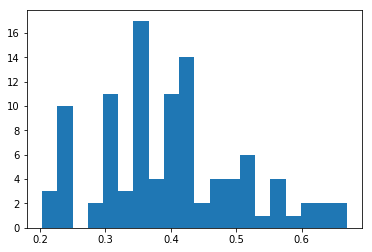

In [33]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

We can view the learned accuracy parameters, and other statistics about the LFs learned by the generative model:

In [34]:
gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.562949,0.6688,0.560753,0.369570
1,0.629630,0.6696,0.627631,0.423824
2,0.564750,0.6695,0.565599,0.374575
3,0.582702,0.6729,0.580828,0.390591
4,0.538878,0.6649,0.538062,0.352352
5,0.562715,0.6689,0.560671,0.368168
6,0.547262,0.6739,0.545951,0.360360
7,0.559994,0.6684,0.565561,0.372172
8,0.546096,0.6660,0.542133,0.368368
9,0.554498,0.6725,0.555955,0.371972


### Using the Model to Iterate on Labeling Functions

Now that we have learned the generative model, we can stop here and use this to potentially debug and/or improve our labeling function set.  First, we apply the LFs to our development set:

In [35]:
L_dev = labeler.apply_existing(split=1)

 17%|█▋        | 4/24 [00:00<00:00, 31.24it/s]

Clearing existing...
Running UDF...
{74: 98, 'VerbForm': 'part', 'Tense': 'past', 'Aspect': 'perf'}


 71%|███████   | 17/24 [00:00<00:00, 13.67it/s]

{74: 98, 'VerbForm': 'inf'}


 92%|█████████▏| 22/24 [00:01<00:00, 16.70it/s]

{74: 98, 'VerbForm': 'part', 'Tense': 'past', 'Aspect': 'perf'}
{74: 98, 'VerbForm': 'part', 'Tense': 'pres', 'Aspect': 'prog'}
{74: 98, 'VerbForm': 'inf'}
{74: 98, 'VerbForm': 'fin', 'Tense': 'past'}


100%|██████████| 24/24 [00:01<00:00, 18.12it/s]

{74: 98, 'VerbForm': 'inf'}
{74: 98, 'VerbForm': 'part', 'Tense': 'pres', 'Aspect': 'prog'}


And finally, we get the score of the generative model:

In [36]:
tp, fp, tn, fn = gen_model.error_analysis(session, L_dev, L_gold_dev)

Scores (Un-adjusted)
Pos. class accuracy: 0.0
Neg. class accuracy: 1.0
Precision            0.0
Recall               0.0
F1                   0.0
----------------------------------------
TP: 0 | FP: 0 | TN: 22 | FN: 2



### Interpreting Generative Model Performance

At this point, we should be getting an F1 score of around 0.4 to 0.5 on the development set, which is pretty good!  However, we should be very careful in interpreting this. Since we developed our labeling functions using this development set as a guide, and our generative model is composed of these labeling functions, we expect it to score very well here!  

In fact, it is probably somewhat _overfit_ to this set. However this is fine, since in the next tutorial, we'll train a more powerful end extraction model which will generalize beyond the development set, and which we will evaluate on a _blind_ test set (i.e. one we never looked at during development).

### Doing Some Error Analysis

At this point, we might want to look at some examples in one of the error buckets. For example, one of the false negatives that we did not correctly label as true mentions.  To do this, we can again just use the `Viewer`:

In [37]:
from snorkel.viewer import SentenceNgramViewer

# NOTE: This if-then statement is only to avoid opening the viewer during automated testing of this notebook
# You should ignore this!
import os
if 'CI' not in os.environ:
    sv = SentenceNgramViewer(fp, session)
else:
    sv = None

<IPython.core.display.Javascript object>

In [ ]:
sv

In [ ]:
c = sv.get_selected() if sv else list(fp.union(fn))[0]
c

We can easily see the labels that the LFs gave to this candidate using simple ORM-enabled syntax:

In [ ]:
c.labels

We can also now explore some of the additional functionalities of the `lf_stats` method for our dev set LF labels, `L_dev`: we can plug in the gold labels that we have, and the accuracies that our generative model has learned:

In [ ]:
L_dev.lf_stats(session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

Note that for labeling functions with low coverage, our learned accuracies are closer to our prior of 70% accuracy.

### Saving our training labels

Finally, we'll save the `training_marginals`, which are our **probabilistic training labels**, so that we can use them in the next tutorial to train our end extraction model:

In [ ]:
from snorkel.annotations import save_marginals
%time save_marginals(session, L_train, train_marginals)

Next, in Part III, we'll use these probabilistic training labels to train a deep neural network.